In [1]:
import os
import sys
import numpy as np
import loompy
import matplotlib.pyplot as plt
import velocyto as vcy
import logging

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [2]:
fdir = '/data/proj/chromium/10X280_1_ABCD_1'
f = os.path.join(fdir, 'velocyto/10X280_1_ABCD_1.loom')
f_clusters = os.path.join(fdir, 'outs/analysis/clustering/gex/graphclust/clusters.csv')

In [3]:
labels = np.genfromtxt(f_clusters, delimiter=',', skip_header=1, usecols=1)

In [4]:
## Load the velocyto object and add labels
vlm = vcy.VelocytoLoom(f)
vlm.set_clusters(labels)

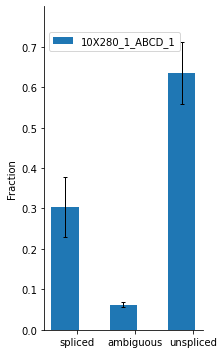

In [5]:
vlm.normalize("S", size=True, log=True)
vlm.S_norm  # contains log normalized

vlm.plot_fractions()

In [6]:
## Filter

vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))

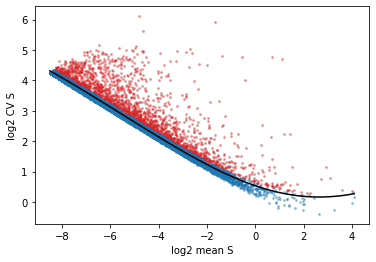

In [7]:
## Filter genes

# vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.score_detection_levels(min_expr_counts=10, min_cells_express=30)   ## nuclei data
vlm.filter_genes(by_detection_levels=True)

## Select genes
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=20)
vlm.filter_genes(by_cv_vs_mean=True)

In [8]:
## Normalize Spliced/Unspliced layers

vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

131

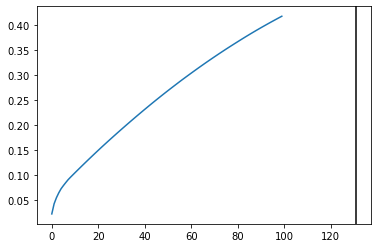

In [9]:
## Perform PCA
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [10]:
## Generate KNN
vlm.knn_imputation(n_pca_dims=40, k=500, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=16)

In [11]:
## Fit distribution
vlm.fit_gammas()

# vlm.plot_phase_portraits(["Nanog"])

In [12]:
## Calculate velocity
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

## 
vlm.calculate_shift(assumption="constant_unspliced", delta_t=10)
vlm.extrapolate_cell_at_t(delta_t=1.)

/home/camiel/git_repos/velocyto.py/velocyto/analysis.py:1406: RuntimeWarning: invalid value encountered in true_divide
  self.delta_S = self.Sx_sz * egt + (1 - egt) * Ux_szo / self.gammas[:, None] - self.Sx_sz


In [13]:
## Generate a tSNE

from sklearn.manifold import TSNE
bh_tsne = TSNE()
vlm.ts = bh_tsne.fit_transform(vlm.pcs[:, :25])

In [14]:
## Calculate transition probabilities

vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=3500, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

/home/camiel/anaconda3/envs/velocyto/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


2021-01-28 15:26:03,129 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2021-01-28 15:26:03,718 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.


2021-01-28 15:26:49,704 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


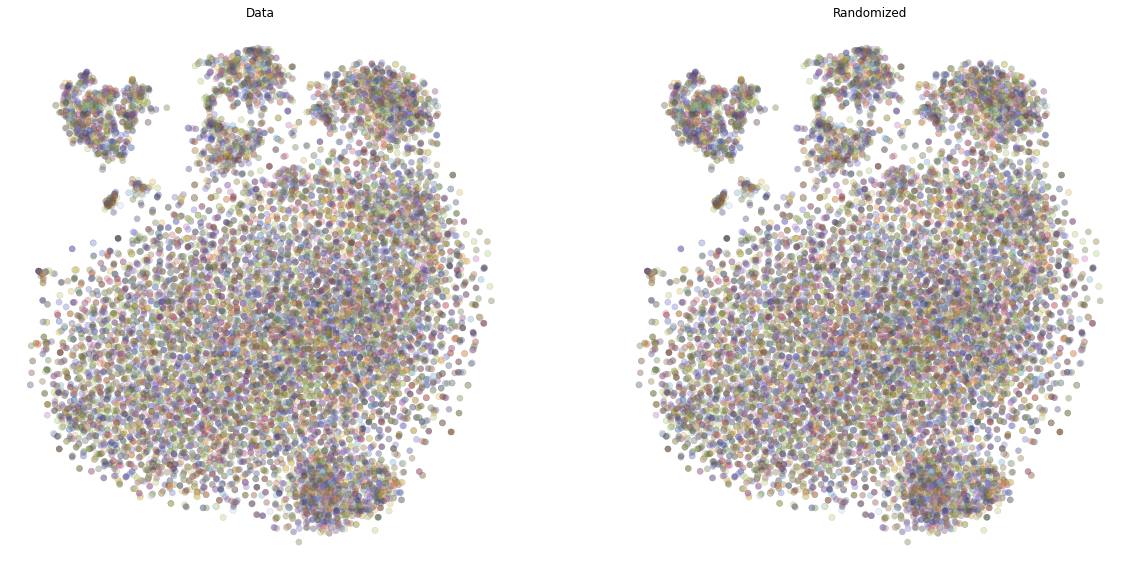

In [15]:
## Plot shift on embedding

vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)
plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale=0.6,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=24, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                    plot_random=True, scale_type="absolute")